Lets take a look at the data. First, let's look at the number of customers per day over all the stores.

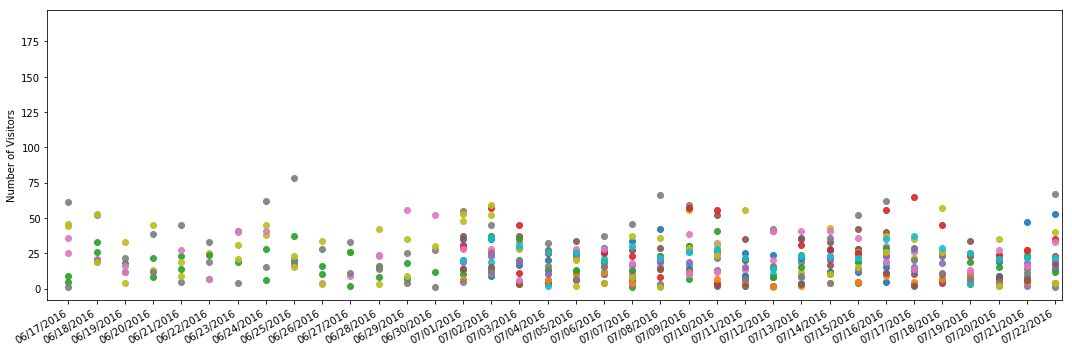

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import datetime

# Read the table
t = pd.read_csv('data/air_visit_data.csv')

# Lets make the weekdays a little easier of a format to deal with
days  = np.array([datetime.datetime.strptime(i, "%Y-%m-%d") for i in t['visit_date']])
dates = matplotlib.dates.date2num(days)

# Plot the number of customers per restaurant. 
# Let's just look at the first 20 restaurants
count = 0
plt.figure(figsize=(15,5))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

for restaurant in np.unique(t['air_store_id']):
    i = np.where(t['air_store_id'] == restaurant)[0]
    plt.plot_date(dates[i], t['visitors'][i], label=restaurant, alpha=0.9, marker='o', linestyle='None')
    count += 1
    if count == 20: break

# Let's just look at the first 35 days (there's too much data to visualize this way)
plt.gcf().autofmt_xdate()
plt.xlim(736131.25, 736131.25+36)

# format the ticks
plt.ylabel('Number of Visitors')
plt.tight_layout()
plt.show()

Interesting. There's definitely a visible trend going on there. What if we look at all the restaurants?

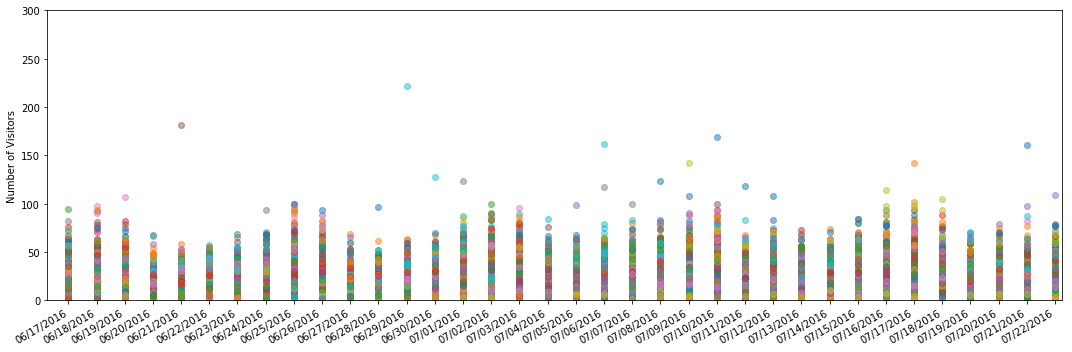

In [2]:
# Plot the number of customers per restaurant. 
# Let's just look at the first 8 restaurants

plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

for restaurant in np.unique(t['air_store_id']):
    i = np.where(t['air_store_id'] == restaurant)[0]
    plt.plot_date(dates[i], t['visitors'][i], label=restaurant, alpha=0.5, marker='o', linestyle='None')

# Let's just look at the first 35 days again
plt.gcf().autofmt_xdate()
plt.xlim(736131.25, 736131.25+36)

# format the ticks (we remove some outliers here for ease of visualization)
plt.ylim(0, 300)
#plt.legend(frameon=False)
plt.ylabel('Number of Visitors')
plt.tight_layout()
plt.show()

Do you see it now? There is a weekly trend. Let's look at it as a boxplot separated by day of the week.

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


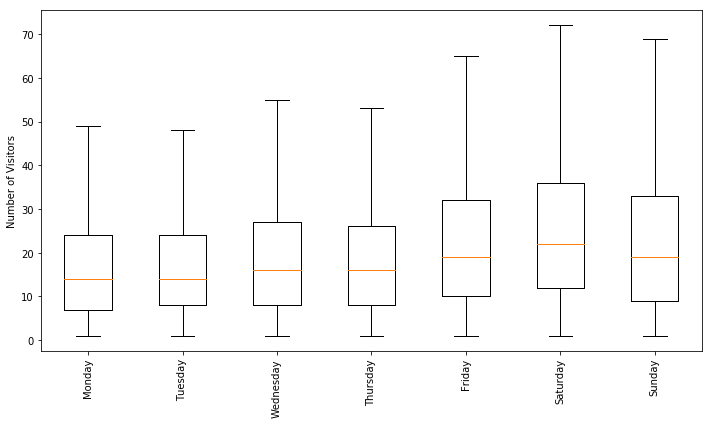

In [3]:
weekdays = np.array([int(datetime.datetime.strptime(i, "%Y-%m-%d").weekday()) for i in t['visit_date']])
labels2 = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10,6))
data = []
for j in range(0,7):
    i = np.where(weekdays == j)[0]
    data.append(t['visitors'][i])

plt.boxplot(data, labels=labels2, showfliers=False)
plt.xticks(rotation='vertical')
plt.ylabel('Number of Visitors')
plt.tight_layout()
plt.show()

So Monday is typically the slowest day, and Saturday is the busiest day. What if we just focus on one store for a little while. Let's look at the store with the most days.

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


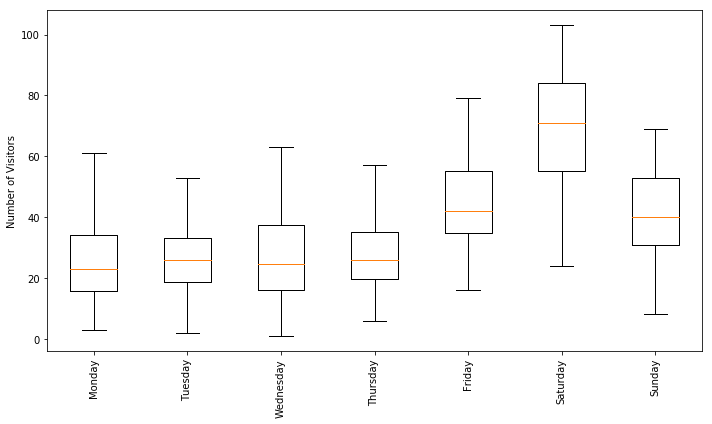

In [4]:
count = 0
for restaurant in np.unique(t['air_store_id']):
    i = np.where(t['air_store_id'] == restaurant)[0]
    if len(i) > count: 
        count = len(i)
        restaurant0 = restaurant
  
plt.figure(figsize=(10,6))
data = []

for j in range(0,7):
    i = np.where( (t['air_store_id'] == restaurant0) & (weekdays == j) )[0]
    data.append(t['visitors'][i])

plt.boxplot(data, labels=labels2, showfliers=False)
plt.xticks(rotation='vertical')
plt.ylabel('Number of Visitors')
plt.tight_layout()
plt.show()


Let's try and use the first year's data to predict the second year's data.

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


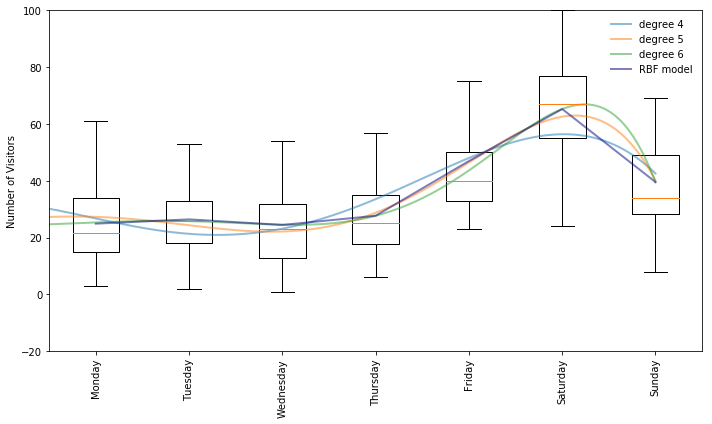

In [5]:
plt.figure(figsize=(10,6))
data = []
x    = []
y    = []

for j in range(0,7):
    i = np.where( (t['air_store_id'] == restaurant0) & (weekdays == j) & (dates < (matplotlib.dates.date2num(datetime.datetime.strptime('2017-01-01', "%Y-%m-%d")))) )[0]
    data.append(t['visitors'][i])
    y.append(np.mean(t['visitors'][i]))
    x.append(j+1)

# Plot the 2017 data
plt.boxplot(data, labels=labels2, showfliers=False)
    
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# generate points used to plot
x_plot = np.linspace(0, 7, 1000)

# create matrix versions of these arrays
X = np.array(x)[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

# Plot up different polynomial fits
for count, degree in enumerate([4, 5, 6]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, lw=2, alpha=0.5,
             label="degree %d" % degree)

from sklearn.svm import SVR
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e4, gamma=0.1)
svr_model = svr_rbf.fit(X, y)
y_rbf = svr_model.predict(X)
plt.plot(X, y_rbf, color='navy', label='RBF model', lw=2, alpha=0.5)

plt.legend(frameon=False)
    
plt.ylim(-20, 100)
plt.xticks(rotation='vertical')
plt.ylabel('Number of Visitors')
plt.tight_layout()
plt.show()

A 6th order polynomial (green line) does a pretty good job of replicating the trend we see.
Let's compare the polynomial fit we get using the 2016 data and compare it to the 2017 data.

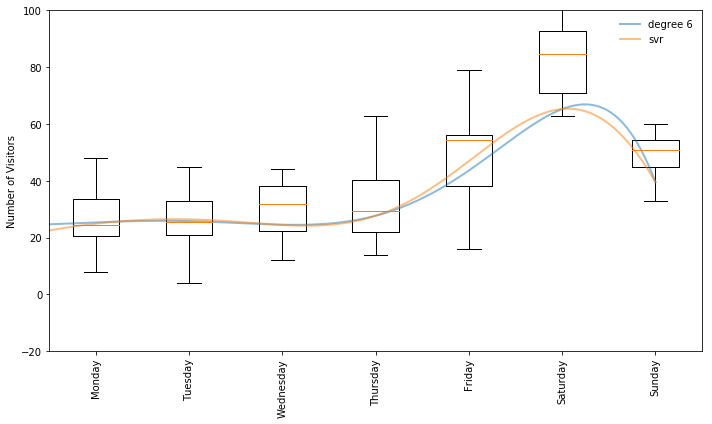

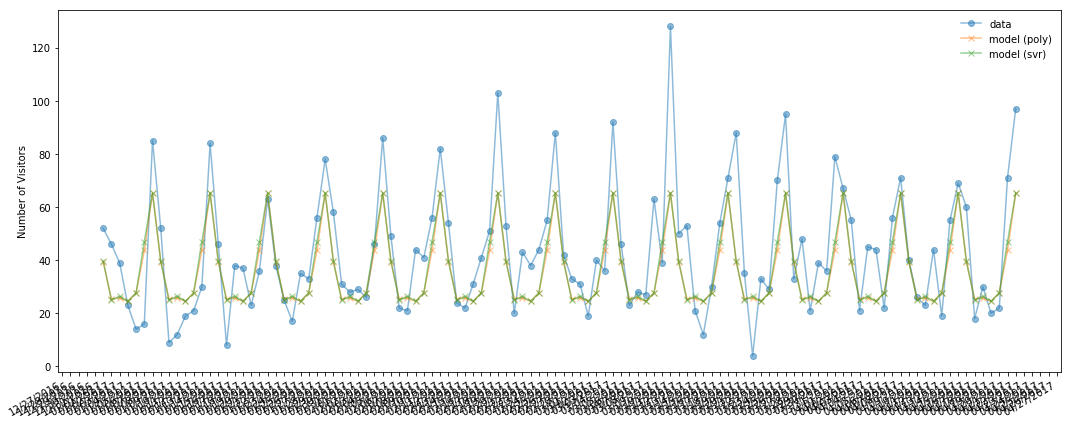

In [6]:
plt.figure(figsize=(10,6))
data  = []
x     = []
y     = []
data2 = []
x2    = []
y2    = []

for j in range(0,7):
    i = np.where( (t['air_store_id'] == restaurant0) & (weekdays == j) & (dates < (matplotlib.dates.date2num(datetime.datetime.strptime('2017-01-01', "%Y-%m-%d")))) )[0]
    data.append(t['visitors'][i])
    y.append(np.mean(t['visitors'][i]))
    x.append(j+1)
    i = np.where( (t['air_store_id'] == restaurant0) & (weekdays == j) & (dates >= (matplotlib.dates.date2num(datetime.datetime.strptime('2017-01-01', "%Y-%m-%d")))) )[0]
    data2.append(t['visitors'][i])
    y2.append(np.mean(t['visitors'][i]))
    x2.append(j+1)

# Plot the 2017 data
plt.boxplot(data2, labels=labels2, showfliers=False)
    
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# generate points used to plot
x_plot = np.linspace(0, 7, 1000)

# create matrix versions of these arrays
#print(x)
X = np.array(x)[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

model = make_pipeline(PolynomialFeatures(6), Ridge())
model.fit(X, y)
y_plot  = model.predict(X_plot)
y_plot2 = svr_model.predict(X_plot)
plt.plot(x_plot, y_plot, lw=2, alpha=0.5, label="degree %d" % degree)
plt.plot(x_plot, y_plot2, lw=2, alpha=0.5, label="svr")


plt.legend(frameon=False)
    
plt.ylim(-20, 100)
plt.xticks(rotation='vertical')
plt.ylabel('Number of Visitors')
plt.tight_layout()



restaurants2 = np.array(t['air_store_id'][np.where( (t['air_store_id'] == restaurant0) & (dates >= (matplotlib.dates.date2num(datetime.datetime.strptime('2017-01-01', "%Y-%m-%d")))) )[0]])
newdates2    = weekdays[np.where( (t['air_store_id'] == restaurant0) & (dates >= (matplotlib.dates.date2num(datetime.datetime.strptime('2017-01-01', "%Y-%m-%d")))))]
dates0002    = dates[np.where( (t['air_store_id'] == restaurant0) & (dates >= (matplotlib.dates.date2num(datetime.datetime.strptime('2017-01-01', "%Y-%m-%d")))))]
newvisitors2 = np.array(t['visitors'][np.where( (t['air_store_id'] == restaurant0) & (dates >= (matplotlib.dates.date2num(datetime.datetime.strptime('2017-01-01', "%Y-%m-%d")))) )[0]])
ind2         = np.argsort(dates0002)

prediction  = []
prediction2 = []
for i in range(len(restaurants2)):
    prediction.append(model.predict(newdates2[i]+1)[0])
    prediction2.append(svr_model.predict(newdates2[i]+1)[0])

plt.figure(figsize=(15,6))
    
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.plot_date(dates0002, newvisitors2, 'o-', label='data', alpha=0.5)
plt.plot_date(dates0002, prediction, 'x-', label='model (poly)', alpha=0.5)
plt.plot_date(dates0002, prediction2, 'x-', label='model (svr)', alpha=0.5)
#plt.plot_date(dates000, prediction-newvisitors, '-', label='model-data', alpha=0.5)

# Let's just look at the first 35 days again
plt.gcf().autofmt_xdate()

# format the ticks (we remove some outliers here for ease of visualization)
#plt.ylim(0, 300)
plt.legend(frameon=False)
plt.ylabel('Number of Visitors')
plt.tight_layout()
plt.show()

plt.show()

That's not great, but it's not terrible either. Maybe we need to consider some other aspects of the data. Let's look at growth over time.

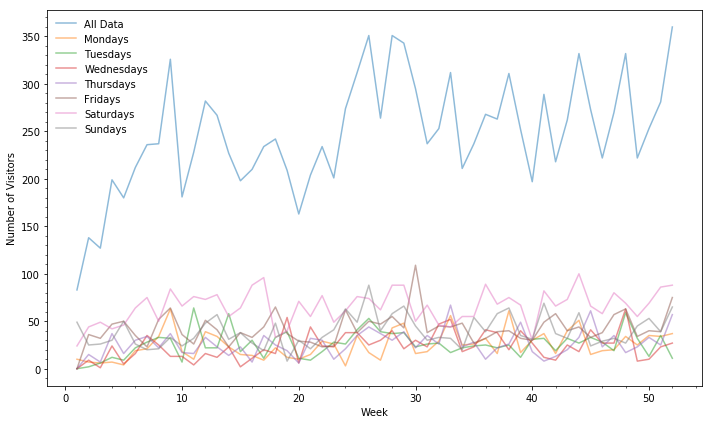

In [7]:
# Let's sort the data by date
restaurants = np.array(t['air_store_id'][np.where( (t['air_store_id'] == restaurant0) & (dates < (matplotlib.dates.date2num(datetime.datetime.strptime('2017-01-01', "%Y-%m-%d")))) )[0]])
newdates    = weekdays[np.where( (t['air_store_id'] == restaurant0) & (dates < (matplotlib.dates.date2num(datetime.datetime.strptime('2017-01-01', "%Y-%m-%d")))))]
dates000    = dates[np.where( (t['air_store_id'] == restaurant0) & (dates < (matplotlib.dates.date2num(datetime.datetime.strptime('2017-01-01', "%Y-%m-%d")))))]
newvisitors = np.array(t['visitors'][np.where( (t['air_store_id'] == restaurant0) & (dates < (matplotlib.dates.date2num(datetime.datetime.strptime('2017-01-01', "%Y-%m-%d")))) )[0]])
ind1        = np.argsort(dates000)

visitors = 0
data     = []
day0     = 0
Monday    = 0
Tuesday   = 0
Wednesday = 0
Thursday  = 0
Friday    = 0
Saturday  = 0
Sunday    = 0
Mondays    = []
Tuesdays   = []
Wednesdays = []
Thursdays  = []
Fridays    = []
Saturdays  = []
Sundays    = []

for j in range(len(newdates)):
    
    day = newdates[j]
    visitors += newvisitors[j]
    if day == 0: Monday += newvisitors[j]
    if day == 1: Tuesday += newvisitors[j]
    if day == 2: Wednesday += newvisitors[j]
    if day == 3: Thursday += newvisitors[j]
    if day == 4: Friday += newvisitors[j]
    if day == 5: Saturday += newvisitors[j]
    if day == 6: Sunday += newvisitors[j]
        
    if day < day0:
        
        data.append(visitors)
        Mondays.append(Monday)
        Tuesdays.append(Tuesday)
        Wednesdays.append(Wednesday)
        Thursdays.append(Thursday)
        Fridays.append(Friday)
        Saturdays.append(Saturday)
        Sundays.append(Sunday)
        day0 = day
        visitors = 0
        Monday = 0
        Tuesday = 0
        Wednesday = 0
        Thursday = 0
        Friday = 0
        Saturday = 0
        Sunday = 0
        continue
        
    day0 = day

plt.figure(figsize=(10,6))

plt.plot(np.arange(len(data))+1, data, label='All Data', alpha=0.5)
plt.plot(np.arange(len(Mondays))+1, Mondays, label='Mondays', alpha=0.5)
plt.plot(np.arange(len(Tuesdays))+1, Tuesdays, label='Tuesdays', alpha=0.5)
plt.plot(np.arange(len(Wednesdays))+1, Wednesdays, label='Wednesdays', alpha=0.5)
plt.plot(np.arange(len(Thursdays))+1, Thursdays, label='Thursdays', alpha=0.5)
plt.plot(np.arange(len(Fridays))+1, Fridays, label='Fridays', alpha=0.5)
plt.plot(np.arange(len(Saturdays))+1, Saturdays, label='Saturdays', alpha=0.5)
plt.plot(np.arange(len(Sundays))+1, Sundays, label='Sundays', alpha=0.5)
plt.xlabel('Week')
plt.ylabel('Number of Visitors')
plt.legend(frameon=False)
plt.minorticks_on()
plt.tight_layout()
plt.show()


Looks like there could be a trend in there, although the variation within any given day appears a little flat. Why don't we just try and model the entire year?

2016: 5
2017: 6


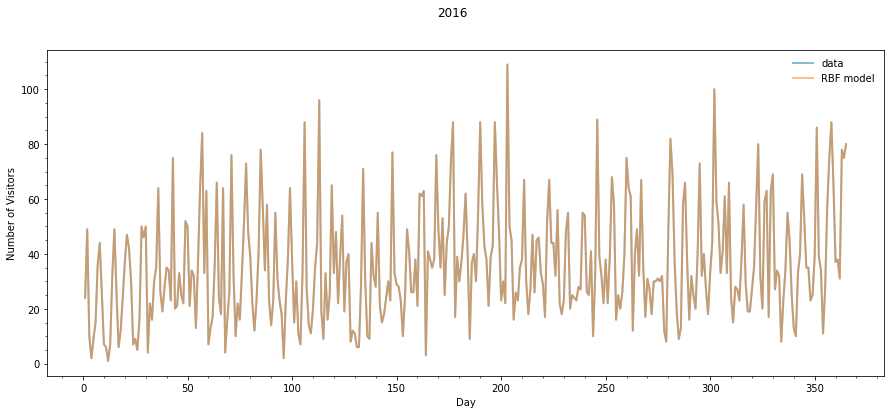

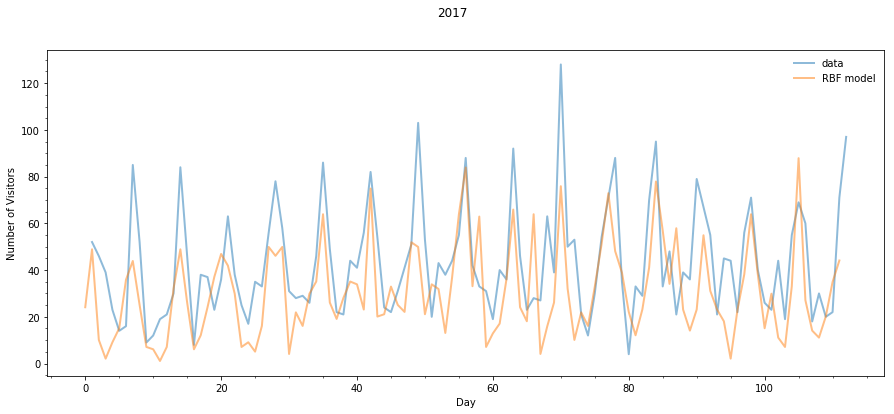

In [8]:
# Let's convert the dates from 1 to 365
newdates000 = dates000[ind1] - np.min(dates000)+1
X           = np.array(newdates000)[:, np.newaxis]

plt.figure(figsize=(15,6))

# Fit regression model
svr_rbf   = SVR(kernel='rbf', C=1e3, gamma='auto')
svr_model = svr_rbf.fit(X, newvisitors[ind1])
y_rbf     = svr_model.predict(X)
plt.plot(X, newvisitors[ind1], label='data', lw=2, alpha=0.5)
plt.plot(X, y_rbf, label='RBF model', lw=2, alpha=0.5)
plt.minorticks_on()
plt.legend(frameon=False)
plt.xlabel('Day')
plt.ylabel('Number of Visitors')
plt.suptitle('2016')


# Now let's do 2017
# First we need to know what day 2016 started on. 
print('2016:', newdates[ind1][0]) # Monday = 0, etc.
print('2017:', newdates2[ind2][0]) # Monday = 0, etc.

newdates0002 = dates0002[ind2] - np.min(dates0002)+1
X            = np.array(newdates0002)[:, np.newaxis]

plt.figure(figsize=(15,6))

# Use the model for 2017
y_rbf     = svr_model.predict(X)

plt.plot(X, newvisitors2[ind2], label='data', lw=2, alpha=0.5)

# Looks like 2017 starts one day later, so we need to offset by another day.
plt.plot(X-1, y_rbf, label='RBF model', lw=2, alpha=0.5)

plt.minorticks_on()
plt.legend(frameon=False)
plt.xlabel('Day')
plt.ylabel('Number of Visitors')
plt.suptitle('2017')


plt.show()

What if we look at some holidays compared to the typically values for that day?

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


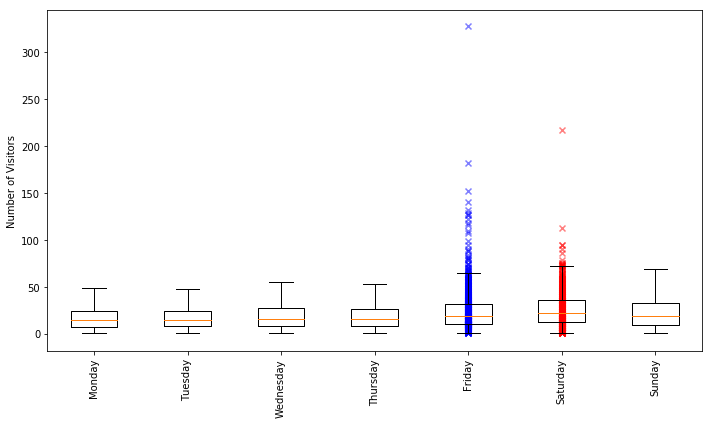

In [9]:
ChristmasEve = int(datetime.datetime.strptime('2016-12-24', "%Y-%m-%d").weekday())
Christmas    = int(datetime.datetime.strptime('2016-12-25', "%Y-%m-%d").weekday())

plt.figure(figsize=(10,6))
data = []
for j in range(0,7):
    i = np.where(weekdays == j)[0]
    data.append(t['visitors'][i])

plt.boxplot(data, labels=labels2, showfliers=False)
c1 = np.where(t['visit_date'] == '2016-12-24')[0]
plt.scatter(np.zeros(len(c1))+ChristmasEve, t['visitors'][c1], alpha=0.5, color='b', marker='x')
c2 = np.where(t['visit_date'] == '2016-12-25')[0]
plt.scatter(np.zeros(len(c2))+Christmas, t['visitors'][c2], alpha=0.5, color='r', marker='x')
plt.xticks(rotation='vertical')
plt.ylabel('Number of Visitors')
plt.tight_layout()
plt.show()